# Dataset Preprocessing

In [29]:
import json
import pandas as pd


with open("exercises.json", "r") as file:
    exercises = json.load(file)

for exercise in exercises:
    exercise["images"] = [image.split('/')[-1] for image in exercise["images"]]

dataframe = pd.DataFrame(exercises)

dataframe.to_csv("exercises_cleaned.csv", index=False, sep=',')
df = pd.read_csv("exercises_cleaned.csv")

df['images'] = df['images'].apply(lambda x: [image.strip(" '") for image in x.strip("[]").split(", ")])
df['secondaryMuscles'] = df['secondaryMuscles'].apply(lambda x: x.strip("[]").replace("'", ""))
df['primaryMuscles'] = df['primaryMuscles'].apply(lambda x: x.strip("[]").replace("'", ""))
df['instructions'] = df['instructions'].apply(lambda x: x.strip("[]").replace("'", ""))
df['images'] = df['images'].apply(lambda x: ",".join(x))

df

,name,force,level,mechanic,equipment,primaryMuscles,secondaryMuscles,instructions,category,images,id
0,3/4 Sit-Up,pull,beginner,compound,body only,abdominals,,Lie down on the floor and secure your feet. Yo...,strength,"0.jpg,1.jpg",3_4_Sit-Up
1,90/90 Hamstring,push,beginner,NaN,body only,hamstrings,calves,"Lie on your back, with one leg extended straig...",stretching,"0.jpg,1.jpg",90_90_Hamstring
2,Ab Crunch Machine,pull,intermediate,isolation,machine,abdominals,,Select a light resistance and sit down on the ...,strength,"0.jpg,1.jpg",Ab_Crunch_Machine
3,Ab Roller,pull,intermediate,compound,other,abdominals,shoulders,Hold the Ab Roller with both hands and kneel o...,strength,"0.jpg,1.jpg",Ab_Roller
4,Adductor,static,intermediate,isolation,foam roll,adductors,,"Lie face down with one leg on a foam roll., Ro...",stretching,"0.jpg,1.jpg",Adductor
...,...,...,...,...,...,...,...,...,...,...,...
868,Wrist Rotations with Straight Bar,pull,beginner,isolation,barbell,forearms,,Hold a barbell with both hands and your palms ...,strength,"0.jpg,1.jpg",Wrist_Rotations_with_Straight_Bar
869,Yoke Walk,NaN,intermediate,compound,other,quadriceps,"abdominals, abductors, adductors, calves, glut...",The yoke is usually done with a yoke apparatus...,strongman,"0.jpg,1.jpg",Yoke_Walk
870,Zercher Squats,push,expert,compound,barbell,quadriceps,"calves, glutes, hamstrings",This exercise is best performed inside a squat...,strength,"0.jpg,1.jpg",Zercher_Squats
871,Zottman Curl,pull,intermediate,isolation,dumbbell,biceps,forearms,Stand up with your torso upright and a dumbbel...,strength,"0.jpg,1.jpg",Zottman_Curl


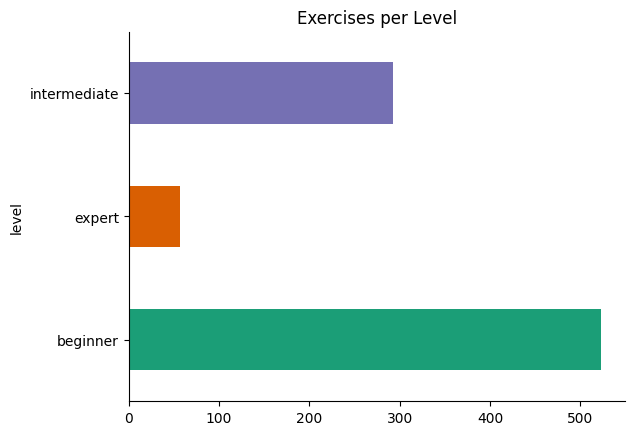

In [30]:
# visualising exercises based on levels
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('level').size().plot(kind='barh', title='Exercises per Level', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:
# replacing null values in the dataset
df.fillna(0, inplace=True)
df.isna().value_counts()

name   force  level  mechanic  equipment  primaryMuscles  secondaryMuscles  instructions  category  images  id   
False  False  False  False     False      False           False             False         False     False   False    873
Name: count, dtype: int64

In [32]:
df.to_csv("exercises-cleaned.csv", index=False, sep=',')

# K Nearest Neighbors

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle

# Load the dataset
dataset = pd.read_csv("exercises-cleaned.csv")

# prioritise weights

fields_to_consider = ['primaryMuscles','level', 'equipment', 'secondaryMuscles', 'force', 'mechanic', 'category']
field_weights = [20, 15, 10, 5, 3, 2, 1]

dataset['main'] = dataset[fields_to_consider].apply(
    lambda row: (
        ' '.join([str(val) * weight for val, weight in zip(row, field_weights)])
    ),
    axis=1
)

# Creating a TF-IDF vectorizer to convert the main column into numerical form
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['main'])

# Scale the data to a range
scaler = StandardScaler()
scaled_features = scaler.fit_transform(tfidf_matrix.toarray())
scaled_data = pd.DataFrame(scaled_features, columns=tfidf_matrix.toarray()[0])

# Fit the model
n_neighbors = min(10, len(scaled_data))
nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
nn_model.fit(scaled_data)

# saving the model
pickle.dump(nn_model, open('model.pkl','wb'))

# User Input
user_input = ["no equipment"]
user_tfidf = tfidf_vectorizer.transform(user_input)
scaled_user_input = scaler.transform(user_tfidf.toarray())

# Find nearest neighbors to the user input
distances, indices = nn_model.kneighbors(scaled_user_input)

# Get recommended exercises
recommended_exercises_indices = indices[0]
recommended_exercises = dataset.iloc[recommended_exercises_indices].to_dict(orient='records')
print("Recommended Exercises:")
for exercise in recommended_exercises:
  print(exercise["name"])


Recommended Exercises:
Upper Back Stretch
Middle Back Shrug
Leverage High Row
Inverted Row
Pelvic Tilt Into Bridge
Standing Pelvic Tilt
Hug Knees To Chest
Hyperextensions (Back Extensions)
Seated Good Mornings
Stiff Leg Barbell Good Morning


# KMeans

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

dataset = pd.read_csv('exercises-cleaned.csv')

fields_to_consider = ['primaryMuscles','level', 'equipment', 'secondaryMuscles', 'force', 'mechanic', 'category']
field_weights = [20, 15, 10, 5, 3, 2, 1]

dataset['main'] = dataset[fields_to_consider].apply(
    lambda row: (
        ' '.join([str(val) * weight for val, weight in zip(row, field_weights)])
    ),
    axis=1
)

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['main'])

# Scale the data to a range
scaler = StandardScaler()
scaled_features = scaler.fit_transform(tfidf_matrix.toarray())
scaled_data = pd.DataFrame(scaled_features, columns=tfidf_matrix.toarray()[0])

from sklearn.cluster import KMeans
k = 10
kmeans_model = KMeans(n_clusters=k, random_state=42)
kmeans_model.fit(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

In [38]:
# User Input
user_input = ["no equipment"]
user_tfidf = tfidf_vectorizer.transform(user_input)
scaled_user_input = scaler.transform(user_tfidf.toarray())

cluster_label = kmeans_model.predict(scaled_user_input)
cluster_data = dataset[kmeans_model.labels_ == cluster_label[0]].to_dict(orient="records")
cluster_data = cluster_data[:10]
print("Cluster Data:")
for exercise in cluster_data:
  print(exercise["name"])

Cluster Data:
3/4 Sit-Up
90/90 Hamstring
Advanced Kettlebell Windmill
Air Bike
All Fours Quad Stretch
Alternate Heel Touchers
Alternate Leg Diagonal Bound
Alternating Hang Clean
Alternating Kettlebell Row
Alternating Renegade Row
